In [1]:
import torch.nn as nn
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
# This UNET-style prediction model was originally included as part of the Score-based generative modelling tutorial
# by Yang Song et al: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.embed(t))
    # Encoding path
    h1 = self.conv1(x)
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [3]:
# ExponentialMovingAverage implementation as used in pytorch vision
# https://github.com/pytorch/vision/blob/main/references/classification/utils.py#L159

# BSD 3-Clause License

# Copyright (c) Soumith Chintala 2016,
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# * Redistributions of source code must retain the above copyright notice, this
#   list of conditions and the following disclaimer.

# * Redistributions in binary form must reproduce the above copyright notice,
#   this list of conditions and the following disclaimer in the documentation
#   and/or other materials provided with the distribution.

# * Neither the name of the copyright holder nor the names of its
#   contributors may be used to endorse or promote products derived from
#   this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay.
    ``ema_avg = decay * avg_model_param + (1 - decay) * model_param``
    `torch.optim.swa_utils.AveragedModel <https://pytorch.org/docs/stable/optim.html#custom-averaging-strategies>`_
    is used to compute the EMA.
    """

    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

In [4]:
class DDPM_epsilon(nn.Module):
    """
    Predict epsilon directly.
    """
    def __init__(self, network, T=1000, beta_1=1e-4, beta_T=2e-2):
        super().__init__()
        self._network = network
        # reshape images inside network(...) call
        self.network = lambda x, t: self._network(
            x.reshape(-1, 1, 28, 28),   # reshape to (N,1,28,28)
            (t.squeeze() / T)          # normalize time to [0,1]
        ).reshape(-1, 28*28)

        self.T = T

        # Register buffers for alpha/beta
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1 - self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))

    def forward_diffusion(self, x0, t, epsilon):
        # q(x_t | x_0)
        alpha_bar_t = self.alpha_bar[t].view(-1,1)  # shape (batch,1)
        mean = torch.sqrt(alpha_bar_t) * x0
        std  = torch.sqrt(1 - alpha_bar_t)
        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon):
        # p(x_{t-1} | x_t)
        # predicted epsilon
        alpha_t      = self.alpha[t].view(-1,1)
        alpha_bar_t  = self.alpha_bar[t].view(-1,1)
        beta_t       = self.beta[t].view(-1,1)

        eps_pred = self.network(xt, t)
        mean = (1.0 / torch.sqrt(alpha_t)) * (
            xt - (beta_t / torch.sqrt(1. - alpha_bar_t)) * eps_pred
        )
        # If t>0, use normal sampling; if t=0, no noise
        mask = (t>0).float().view(-1,1)
        sigma_t = torch.sqrt(((1. - self.alpha_bar[t-1].view(-1,1)) / (1. - alpha_bar_t)) * beta_t)
        return mean + mask*sigma_t*epsilon

    @torch.no_grad()
    def sample(self, shape, device):
        # Algorithm 2 in Ho et al., 2020
        x_t = torch.randn(shape, device=device)
        for step in reversed(range(1, self.T+1)):
            t_batch = torch.tensor(step).expand(x_t.shape[0],1).to(device)
            noise = torch.randn_like(x_t) if step > 1 else 0
            x_t = self.reverse_diffusion(x_t, t_batch, noise)
        return x_t

    def loss(self, x0):
        # Pick random t in [1..T]
        t = torch.randint(1, self.T, (x0.shape[0],1), device=x0.device)
        epsilon = torch.randn_like(x0)
        x_t = self.forward_diffusion(x0, t, epsilon)

        # MSE(eps_pred, eps)
        eps_pred = self.network(x_t, t)
        return nn.MSELoss()(eps_pred, epsilon)


class DDPM_mu(nn.Module):
    """
    Predict mu directly.
    """
    def __init__(self, network, T=1000, beta_1=1e-4, beta_T=2e-2):
        super().__init__()
        self._network = network
        self.network = lambda x, t: self._network(
            x.reshape(-1, 1, 28, 28),
            (t.squeeze() / T)
        ).reshape(-1, 28*28)

        self.T = T

        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1 - self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))

    def forward_diffusion(self, x0, t, epsilon):
        alpha_bar_t = self.alpha_bar[t].view(-1,1)
        mean = torch.sqrt(alpha_bar_t) * x0
        std  = torch.sqrt(1 - alpha_bar_t)
        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon=None):
        alpha_bar_t = self.alpha_bar[t].view(-1,1)
        beta_t      = self.beta[t].view(-1,1)

        # Network returns mu directly
        mu_pred = self.network(xt, t)

        # If t>0, add noise; if t=0, no noise
        mask = (t>0).float().view(-1,1)
        sigma_t = torch.sqrt(((1. - self.alpha_bar[t-1].view(-1,1)) / (1. - alpha_bar_t)) * beta_t)
        noise = epsilon if epsilon is not None else 0
        return mu_pred + mask*sigma_t*noise

    @torch.no_grad()
    def sample(self, shape, device):
        x_t = torch.randn(shape, device=device)
        for step in reversed(range(1, self.T+1)):
            t_batch = torch.tensor(step).expand(x_t.shape[0],1).to(device)
            noise = torch.randn_like(x_t) if step > 1 else 0
            x_t = self.reverse_diffusion(x_t, t_batch, noise)
        return x_t

    def loss(self, x0):
        t = torch.randint(1, self.T, (x0.shape[0],1), device=x0.device)
        epsilon = torch.randn_like(x0)
        xt = self.forward_diffusion(x0, t, epsilon)

        # MSE against the true posterior mean (Ho et al. eqn. (4) rearranged)
        alpha_t     = self.alpha[t].view(-1,1)
        alpha_bar_t = self.alpha_bar[t].view(-1,1)
        beta_t      = self.beta[t].view(-1,1)

        # True mu = 1/sqrt(alpha_t) * ( xt - beta_t / sqrt(1-alpha_bar_t)*epsilon )
        mu_true = (1.0 / torch.sqrt(alpha_t)) * (xt - (beta_t / torch.sqrt(1.-alpha_bar_t)) * epsilon)
        mu_pred = self.network(xt, t)
        return nn.MSELoss()(mu_pred, mu_true)


class DDPM_x0(nn.Module):
    """
    Predict x0 directly.
    """
    def __init__(self, network, T=1000, beta_1=1e-4, beta_T=2e-2):
        super().__init__()
        self._network = network
        self.network = lambda x, t: self._network(
            x.reshape(-1, 1, 28, 28),
            (t.squeeze() / T)
        ).reshape(-1, 28*28)

        self.T = T

        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1 - self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))

    def forward_diffusion(self, x0, t, epsilon):
        alpha_bar_t = self.alpha_bar[t].view(-1,1)
        mean = torch.sqrt(alpha_bar_t) * x0
        std  = torch.sqrt(1 - alpha_bar_t)
        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon=None):
        # x0_pred = network(xt,t)
        x0_pred = self.network(xt, t)
        alpha_bar_t    = self.alpha_bar[t].view(-1,1)
        mu = torch.sqrt(alpha_bar_t)*x0_pred + torch.sqrt(1-alpha_bar_t)*xt

        mask = (t>0).float().view(-1,1)
        sigma_t = torch.sqrt(
            ((1. - self.alpha_bar[t-1].view(-1,1)) / (1. - alpha_bar_t)) * self.beta[t].view(-1,1)
        )
        noise = epsilon if epsilon is not None else 0
        return mu + mask*sigma_t*noise

    @torch.no_grad()
    def sample(self, shape, device):
        x_t = torch.randn(shape, device=device)
        for step in reversed(range(1, self.T+1)):
            t_batch = torch.tensor(step).expand(x_t.shape[0],1).to(device)
            noise = torch.randn_like(x_t) if step > 1 else 0
            x_t = self.reverse_diffusion(x_t, t_batch, noise)
        return x_t

    def loss(self, x0):
        t = torch.randint(1, self.T, (x0.shape[0],1), device=x0.device)
        epsilon = torch.randn_like(x0)
        xt = self.forward_diffusion(x0, t, epsilon)

        # MSE( x0_pred, x0 )
        x0_pred = self.network(xt, t)
        return nn.MSELoss()(x0_pred, x0)

In [5]:
def train(model, optimizer, scheduler, dataloader, epochs, device, ema=True, per_epoch_callback=None):
    """
    Training loop

    Parameters
    ----------
    model: nn.Module
        Pytorch model
    optimizer: optim.Optimizer
        Pytorch optimizer to be used for training
    scheduler: optim.LRScheduler
        Pytorch learning rate scheduler
    dataloader: utils.DataLoader
        Pytorch dataloader
    epochs: int
        Number of epochs to train
    device: torch.device
        Pytorch device specification
    ema: Boolean
        Whether to activate Exponential Model Averaging
    per_epoch_callback: function
        Called at the end of every epoch
    """

    # Setup progress bar
    total_steps = len(dataloader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    if ema:
        ema_global_step_counter = 0
        ema_steps = 10
        ema_adjust = dataloader.batch_size * ema_steps / epochs
        ema_decay = 1.0 - 0.995
        ema_alpha = min(1.0, (1.0 - ema_decay) * ema_adjust)
        ema_model = ExponentialMovingAverage(model, device=device, decay=1.0 - ema_alpha)

    for epoch in range(epochs):

        # Switch to train mode
        model.train()

        global_step_counter = 0
        for i, (x, _) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update progress bar
            progress_bar.set_postfix(loss=f"⠀{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}", lr=f"{scheduler.get_last_lr()[0]:.2E}")
            progress_bar.update()

            if ema:
                ema_global_step_counter += 1
                if ema_global_step_counter%ema_steps==0:
                    ema_model.update_parameters(model)

        if per_epoch_callback:
            per_epoch_callback(ema_model.module if ema else model)


# Parameters
T = 1000
learning_rate = 1e-3
epochs = 100
batch_size = 256


# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020,
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform),
                                                batch_size=batch_size,
                                                shuffle=True)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
#mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))
mnist_unet = ScoreNet(marginal_prob_std=lambda t: torch.ones_like(t))


Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.40MB/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.95MB/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [6]:
def sigma_one(t):
    return torch.ones_like(t).to(device)

mnist_unet_epsilon = ScoreNet(marginal_prob_std=sigma_one).to(device)
mnist_unet_mu      = ScoreNet(marginal_prob_std=sigma_one).to(device)
mnist_unet_x0      = ScoreNet(marginal_prob_std=sigma_one).to(device)

model_epsilon = DDPM_epsilon(network=mnist_unet, T=T).to(device)  # Predicting ε
model_mu = DDPM_mu(network=mnist_unet_mu, T=T).to(device)       # Predicting μ
model_x0 = DDPM_x0(network=mnist_unet_x0, T=T).to(device)       # Predicting x0

def train_and_evaluate(model, model_name, optimizer, scheduler, dataloader, epochs, device):
    """
    Train the model and evaluate its performance.

    Parameters
    ----------
    model: nn.Module
        The diffusion model to be trained.
    model_name: str
        Name of the model for reporting.
    optimizer: torch.optim.Optimizer
        Optimizer for training.
    scheduler: torch.optim.lr_scheduler
        Learning rate scheduler.
    dataloader: torch.utils.data.DataLoader
        DataLoader for training data.
    epochs: int
        Number of training epochs.
    device: torch.device
        Device for training (CPU or GPU).
    """
    losses = []

    def reporter(model):
        """Callback for plotting and reporting samples."""
        model.eval()
        with torch.no_grad():
            nsamples = 10
            samples = model.sample((nsamples, 28 * 28)).cpu()
            samples = (samples + 1) / 2  # Rescale to [0, 1]
            samples = samples.clamp(0.0, 1.0)
            grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
            plt.gca().set_axis_off()
            plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
            plt.title(f"{model_name} Samples")
            plt.show()

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, _ in dataloader:
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()
        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{epochs}, {model_name} Loss: {avg_loss:.4f}")

        if (epoch + 1) % 10 == 0:
            reporter(model)

    return losses

def train_diffusion_model(model, dataloader, epochs, device, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        for x, _ in dataloader:
            x = x.to(device)
            optimizer.zero_grad()
            loss_val = model.loss(x)
            loss_val.backward()
            optimizer.step()
            total_loss += loss_val.item()

        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch}/{epochs}, Loss = {avg_loss:.4f}")
    return losses

def show_samples(model, device, title="Samples", n=8):
    model.eval()
    with torch.no_grad():
        samples = model.sample((n, 28*28), device=device)
    samples = (samples + 1)/2
    samples = samples.clamp(0,1).view(-1,1,28,28)

    grid = utils.make_grid(samples, nrow=n)
    plt.figure(figsize=(8,2))
    plt.axis("off")
    plt.title(title)
    plt.imshow(grid.permute(1,2,0).cpu().numpy(), cmap="gray")
    plt.show()





Using device: cuda
Training DDPM_epsilon (predict epsilon)...
Epoch 1/100, Loss = 0.4947
Epoch 2/100, Loss = 0.1906
Epoch 3/100, Loss = 0.1464
Epoch 4/100, Loss = 0.1279
Epoch 5/100, Loss = 0.1144
Epoch 6/100, Loss = 0.1052
Epoch 7/100, Loss = 0.0985
Epoch 8/100, Loss = 0.0939
Epoch 9/100, Loss = 0.0900
Epoch 10/100, Loss = 0.0873
Epoch 11/100, Loss = 0.0838
Epoch 12/100, Loss = 0.0822
Epoch 13/100, Loss = 0.0802
Epoch 14/100, Loss = 0.0780
Epoch 15/100, Loss = 0.0774
Epoch 16/100, Loss = 0.0749
Epoch 17/100, Loss = 0.0744
Epoch 18/100, Loss = 0.0726
Epoch 19/100, Loss = 0.0716
Epoch 20/100, Loss = 0.0708
Epoch 21/100, Loss = 0.0699
Epoch 22/100, Loss = 0.0690
Epoch 23/100, Loss = 0.0681
Epoch 24/100, Loss = 0.0676
Epoch 25/100, Loss = 0.0667
Epoch 26/100, Loss = 0.0658
Epoch 27/100, Loss = 0.0652
Epoch 28/100, Loss = 0.0647
Epoch 29/100, Loss = 0.0644
Epoch 30/100, Loss = 0.0636
Epoch 31/100, Loss = 0.0632
Epoch 32/100, Loss = 0.0633
Epoch 33/100, Loss = 0.0629
Epoch 34/100, Loss = 0.

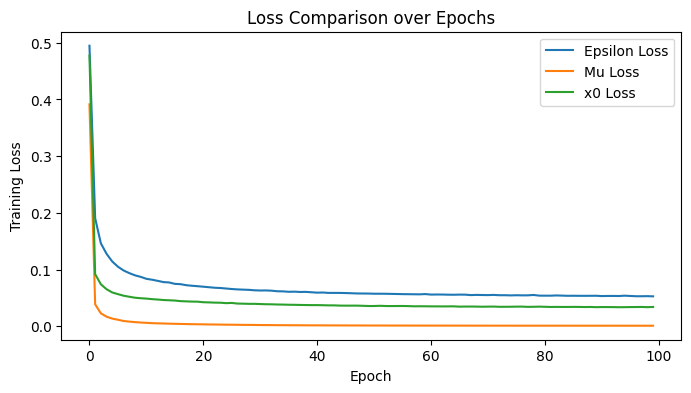

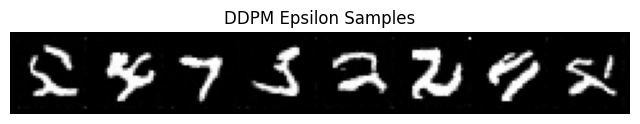

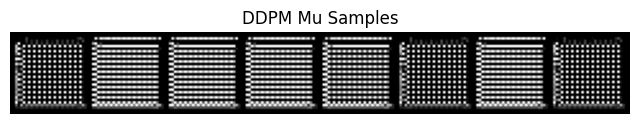

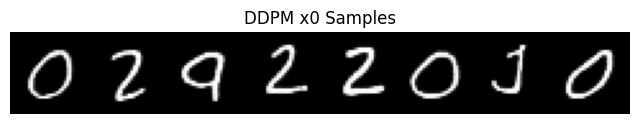

Total training time:
   DDPM_epsilon: 1316.98 s
   DDPM_mu:      1294.39 s
   DDPM_x0:      1277.75 s


In [7]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + torch.rand_like(x)/255.),  # Dequantize
        transforms.Lambda(lambda x: (x - 0.5)*2.0 ),               # Map to [-1,1]
        transforms.Lambda(lambda x: x.flatten())
    ])
    dataset = datasets.MNIST(root="./mnist_data", train=True, download=True, transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

    def sigma_one(t):
        return torch.ones_like(t).to(device)

    mnist_unet_epsilon = ScoreNet(marginal_prob_std=sigma_one).to(device)
    mnist_unet_mu      = ScoreNet(marginal_prob_std=sigma_one).to(device)
    mnist_unet_x0      = ScoreNet(marginal_prob_std=sigma_one).to(device)

    T = 200  
    model_epsilon = DDPM_epsilon(network=mnist_unet_epsilon, T=T).to(device)
    model_mu      = DDPM_mu     (network=mnist_unet_mu,      T=T).to(device)
    model_x0      = DDPM_x0     (network=mnist_unet_x0,      T=T).to(device)

    epochs = 100

    print("Training DDPM_epsilon (predict epsilon)...")
    start_epsilon = time.time()
    losses_epsilon = train_diffusion_model(model_epsilon, dataloader, epochs, device)
    np.save('losses_epsilon.npy', losses_epsilon)
    end_epsilon = time.time()
    epsilon_time = end_epsilon - start_epsilon
    print(f"DDPM_epsilon training took {epsilon_time:.2f} seconds.\n")

    print("Training DDPM_mu (predict mu)...")
    start_mu = time.time()
    losses_mu = train_diffusion_model(model_mu, dataloader, epochs, device)
    np.save('losses_mu.npy', losses_mu)
    end_mu = time.time()
    mu_time = end_mu - start_mu
    print(f"DDPM_mu training took {mu_time:.2f} seconds.\n")

    print("Training DDPM_x0 (predict x0)...")
    start_x0 = time.time()
    losses_x0 = train_diffusion_model(model_x0, dataloader, epochs, device)
    np.save('losses_x0.npy', losses_x0)
    end_x0 = time.time()
    x0_time = end_x0 - start_x0
    print(f"DDPM_x0 training took {x0_time:.2f} seconds.\n")

    plt.figure(figsize=(8,4))
    plt.plot(losses_epsilon, label="Epsilon Loss")
    plt.plot(losses_mu,      label="Mu Loss")
    plt.plot(losses_x0,      label="x0 Loss")
    plt.legend()
    plt.title("Loss Comparison over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.show()

    show_samples(model_epsilon, device, "DDPM Epsilon Samples", n=8)
    show_samples(model_mu,      device, "DDPM Mu Samples",      n=8)
    show_samples(model_x0,      device, "DDPM x0 Samples",      n=8)

    print(f"Total training time:")
    print(f"   DDPM_epsilon: {epsilon_time:.2f} s")
    print(f"   DDPM_mu:      {mu_time:.2f} s")
    print(f"   DDPM_x0:      {x0_time:.2f} s")
